In [1]:
import sys
sys.path.append("/vol/miltank/users/kaiserj/Clipping_vs_Sampling/")


  0%|          | 0/20 [00:00<?, ?it/s]/vol/miltank/users/kaiserj/Clipping_vs_Sampling/opacus_new/accountants/analysis/rdp.py:328: RuntimeWarning: divide by zero encountered in log
  - (np.log(delta) + np.log(orders_vec)) / (orders_vec - 1)
/vol/miltank/users/kaiserj/Clipping_vs_Sampling/opacus_new/accountants/analysis/rdp.py:340: UserWarning: Optimal order is the smallest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
  0%|          | 0/20 [00:00<?, ?it/s]/tmp/ipykernel_1104862/2834980675.py:9: RuntimeWarning: invalid value encountered in multiply
  return np.maximum(0, np.maximum(1 - delta - np.exp(epsilon) * alpha,
100%|██████████| 20/20 [00:00<00:00, 52232.93it/s]
20it [00:00, 57.62it/s]


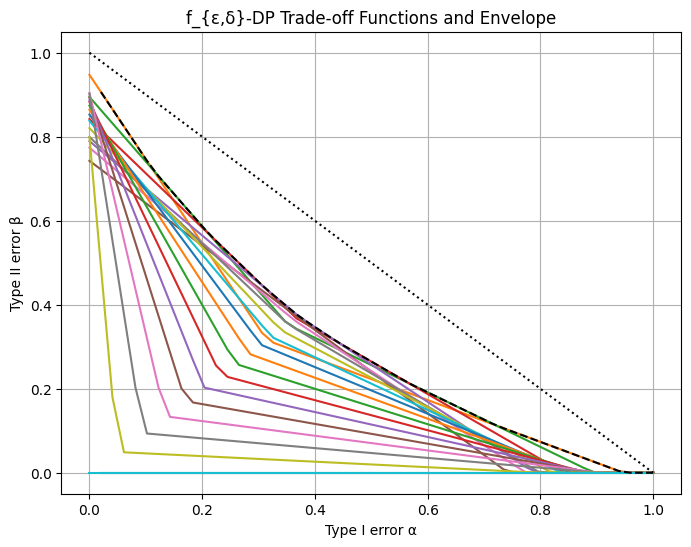

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import opacus_new  # your local Opacus version
from tqdm import tqdm
from opacus_new.accountants.rdp import RDPAccountant

def f_eps_delta(alpha, epsilon, delta):
    """Piecewise linear trade-off function f_{epsilon, delta}."""
    return np.maximum(0, np.maximum(1 - delta - np.exp(epsilon) * alpha,
                                     np.exp(-epsilon) * (1 - delta - alpha)))

# -----------------------------
# Define DP-SGD parameters
# -----------------------------
steps = 1000            # number of steps (iterations)
noise_multiplier = 0.7  # Gaussian noise multiplier
batch_size = 256        # batch size
sample_size = 50000     # dataset size

# -----------------------------
# Define delta range for evaluation
# -----------------------------
deltas = np.linspace(0, 1, 20)  # realistic range of delta values

# -----------------------------
# Initialize accountant
# -----------------------------
accountant = RDPAccountant()

# Simulate DP-SGD steps
for _ in range(steps):
    accountant.step(noise_multiplier=noise_multiplier,
                    sample_rate=batch_size/sample_size)

# Compute epsilon for each delta
epsilons = []
for delta in tqdm(deltas):
    epsilons.append(accountant.get_epsilon(delta))
epsilons = np.array(epsilons) 

eps_delta_pairs = [(eps, delt) for eps, delt in zip(epsilons, deltas)]

# Grid of type I error alpha
alpha = np.linspace(0, 1, 50)

# Compute f functions for each pair
f_values = []
for eps, delta in tqdm(eps_delta_pairs):
    f_values.append(f_eps_delta(alpha, eps, delta))

f_values = np.array(f_values)

# Compute the envelope (pointwise maximum)
envelope = np.max(f_values, axis=0)

# Plot
plt.figure(figsize=(8,6))
for (eps, delta), f_value in tqdm(zip(eps_delta_pairs, f_values)):
    plt.plot(alpha, f_value, label=f"ε={eps}, δ={delta}")
plt.plot(alpha, envelope, 'k--', label='Envelope (max)')
plt.plot([0,1],[1,0],'k:', label='y=1-x')
plt.xlabel("Type I error α")
plt.ylabel("Type II error β")
plt.title("f_{ε,δ}-DP Trade-off Functions and Envelope")
plt.grid(True)
plt.show()
